<a href="https://colab.research.google.com/github/musicnova/ml_keras/blob/master/%D0%9C%D0%B0%D1%80%D0%B0%D1%84%D0%BE%D0%BD_%D1%81%D0%BB%D0%BE%D0%B8_Keras_%D0%94%D0%B5%D0%BD%D1%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**План занятия**

1. Загрузка датасета ОБНАРУЖЕНИЕ МИН. Подготовка данных
2. Создание и обучение модели 
3. Гиперпараметры модели
    * Функции ошибок
    * Оптимизаторы
    * Активационные функции
    * Эпохи
    * batch_size
4. Слой Dense
5. Слой BatchNormalization
6. Слой Dropout


In [ ]:
#@title сервисные функции
!pip -q install tabulate
import gdown
import pandas as pd  
from keras import backend as K
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
class Worker:
  url_ds = 'https://storage.yandexcloud.net/aiueducation/marketing/marathon/sonardata.csv'
  obj_rock = 'камень'
  obj_mine = 'мина'

  def __init__(self):
    self.df = None
    pass

  def load_data(self):
    print(f'{bcolors.BOLD}Загрузка датасета:', end='')
    fname = gdown.download(self.__class__.url_ds, None, quiet=True)
    self.df = pd.read_csv(fname, header=0, index_col=0)
    print(f'{bcolors.OKGREEN} Done {bcolors.ENDC}')
    print()
    print(f'{bcolors.BOLD}Информация о датасете:{bcolors.ENDC}')
    print(f'  {bcolors.OKBLUE}размер:{bcolors.ENDC} {self.df.shape[0]} записей')
    print(f'  {bcolors.OKBLUE}объект {self.__class__.obj_rock}:{bcolors.ENDC} {(self.df["Объект"].values==self.__class__.obj_rock).sum()} записей')
    print(f'  {bcolors.OKBLUE}объект {self.__class__.obj_mine}:{bcolors.ENDC} {(self.df["Объект"].values==self.__class__.obj_mine).sum()} записей')
    print(f'Каждая запись содержит 60 параметров, полученных с эхолота при обнаружении объекта (мина или камень)')
    print()
    print(f'{bcolors.HEADER}Примеры для объекта «{self.__class__.obj_rock}»:')
    display(self.df[self.df['Объект']==self.__class__.obj_rock].sample(n=3))
    print()
    print(f'{bcolors.HEADER}Примеры для объекта «{self.__class__.obj_mine}»:{bcolors.ENDC}')
    display(self.df[self.df['Объект']==self.__class__.obj_mine].sample(n=3))

  def create_sets(self):
    print(f'{bcolors.BOLD}Создание обучающей и проверочной выборки:', end='')
    dataset = self.df.replace(self.__class__.obj_mine, 1.).replace(self.__class__.obj_rock, 0.).astype(float).to_numpy()
    x_data = dataset[:, :60]                   
    y_data = dataset[:, 60]
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=2,
                                                    stratify=y_data)
    print(f'{bcolors.OKGREEN} Done {bcolors.ENDC}')
    print()
    print(f'{bcolors.BOLD}Размеры сформированных выборок:{bcolors.ENDC}')
    print(f'  обучающая выборка параметров', self.x_train.shape)
    print(f'  обучающая выборка меток классов', self.y_train.shape)
    print()
    print(f'  тестовая выборка параметров', self.x_test.shape)
    print(f'  тестовая выборка меток классов', self.y_test.shape)

  def plot_graphic(self, history):
    # Обучение модели
    f, ax = plt.subplots(1,2, figsize=(30, 8))
    ax[0].plot(history.history['accuracy'], 
            label='Доля верных ответов на обучающем наборе')
    ax[0].plot(history.history['val_accuracy'], 
            label='Доля верных ответов на проверочном наборе')
    ax[0].set_xlabel('Эпоха обучения')
    ax[0].set_ylabel('Доля верных ответов')

    ax[1].plot(history.history['loss'], 
            label='Ошибка на обучающем наборе')
    ax[1].plot(history.history['val_loss'], 
            label='Ошибка на проверочном наборе')
    ax[1].set_xlabel('Эпоха обучения')
    ax[1].set_ylabel('Ошибка')
    plt.show()

  def layers_demonstration(self, model):
    self.model = model
    print(f'{bcolors.BOLD}{bcolors.OKBLUE}Демонстрация работы Dense-слоя{bcolors.ENDC}')
    print(f'Для примера возьмем случайную запись из тестовой выборки:')
    idx = np.random.choice(self.x_test.shape[0])
    print(f'{bcolors.BOLD}Параметры:\n {bcolors.ENDC}{self.x_test[idx]}')
    if self.y_test[idx]:
      print(f'{bcolors.BOLD}Объект: {bcolors.FAIL}{self.__class__.obj_mine}{bcolors.ENDC}')
    else:
      print(f'{bcolors.BOLD}Объект:{bcolors.OKGREEN} {self.__class__.obj_rock}{bcolors.ENDC}')

    print()
    print()
    print(f'{bcolors.BOLD}Работа нейронной сети{bcolors.ENDC}')
    print('60 параметров подаются на вход нейронной сети')
    print()
    inp = self.model.input
    for i, layer in enumerate(self.model.layers):
      type_layer = layer.__class__.__name__
      outputs = layer.output
      functors = K.function([inp], [outputs])
      layer_outs = functors(self.x_test[idx][None,...])      
      if type_layer=='Dense':
        cnt_units = layer.get_weights()[0].shape[1]        
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}), содержащий {bcolors.BOLD} {cnt_units} нейронов{bcolors.ENDC}')      
        print(f'На выходе слоя получаем вектор из {cnt_units} значений:')
        weights = layer_outs[0][0]
        data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        print(tabulate(data, tablefmt="grid"))
        res = layer_outs[0][0][0]
        print()
        print()
      elif type_layer=='BatchNormalization':
        print(f'Значения поступают на {bcolors.OKBLUE}{i+1}-й слой{bcolors.ENDC} ({type_layer}){bcolors.ENDC}')
        res = layer_outs[0][0]
        print(f'На выходе слоя получаем вектор из {res.shape[0]} значений:')
        weights = layer_outs[0][0]
        data = [weights[i:i+10] for i in range(0, weights.shape[0], 10)]
        print(tabulate(data, tablefmt="grid"))
        print()
        print()
      elif type_layer=='Dropout':
        print(f'Слой {bcolors.BOLD} Dropout{bcolors.ENDC}. Используется только при обучении модели')
        print()

    print(f'{bcolors.BOLD}{bcolors.OKBLUE}Результатом работы нейронной сети является значение: {bcolors.OKGREEN}{round(res,4)}{bcolors.ENDC}')    
    print(f'Таким образом, вероятность того, что рассматриваемый объект {self.__class__.obj_mine} - {bcolors.BOLD}{round(res*100,2)}{bcolors.ENDC}%')
    if res < 0.5:
      print(f'Вероятность менее 50%, следовательно это {bcolors.BOLD}{bcolors.OKGREEN}{self.__class__.obj_rock}{bcolors.ENDC}')
    else:
      print(f'Вероятность более 50%, следовательно это {bcolors.BOLD}{bcolors.FAIL}{self.__class__.obj_mine}{bcolors.ENDC}')
worker=Worker()

In [ ]:
# Загрузка датасета
worker.load_data()

Загрузка датасета: Done 

Информация о датасете:
  размер: 208 записей
  объект камень: 97 записей
  объект мина: 111 записей
Каждая запись содержит 60 параметров, полученных с эхолота при обнаружении объекта (мина или камень)

Примеры для объекта «камень»:


,п_1,п_2,п_3,п_4,п_5,п_6,п_7,п_8,п_9,п_10,...,п_52,п_53,п_54,п_55,п_56,п_57,п_58,п_59,п_60,Объект
17,0.0192,0.0607,0.0378,0.0774,0.1388,0.0809,0.0568,0.0219,0.1037,0.1186,...,0.0331,0.0131,0.0120,0.0108,0.0024,0.0045,0.0037,0.0112,0.0075,камень
48,0.0190,0.0038,0.0642,0.0452,0.0333,0.0690,0.0901,0.1454,0.0740,0.0349,...,0.0093,0.0118,0.0112,0.0094,0.0140,0.0072,0.0022,0.0055,0.0122,камень
58,0.0225,0.0019,0.0075,0.0097,0.0445,0.0906,0.0889,0.0655,0.1624,0.1452,...,0.0034,0.0129,0.0100,0.0044,0.0057,0.0030,0.0035,0.0021,0.0027,камень



Примеры для объекта «мина»:


,п_1,п_2,п_3,п_4,п_5,п_6,п_7,п_8,п_9,п_10,...,п_52,п_53,п_54,п_55,п_56,п_57,п_58,п_59,п_60,Объект
196,0.0050,0.0017,0.0270,0.0450,0.0958,0.0830,0.0879,0.1220,0.1977,0.2282,...,0.0165,0.0056,0.0010,0.0027,0.0062,0.0024,0.0063,0.0017,0.0028,мина
147,0.0654,0.0649,0.0737,0.1132,0.2482,0.1257,0.1797,0.0989,0.2460,0.3422,...,0.0210,0.0361,0.0239,0.0447,0.0394,0.0355,0.0440,0.0243,0.0098,мина
148,0.0712,0.0901,0.1276,0.1497,0.1284,0.1165,0.1285,0.1684,0.1830,0.2127,...,0.0154,0.0156,0.0054,0.0030,0.0048,0.0087,0.0101,0.0095,0.0068,мина


In [ ]:
# Создание выборок
worker.create_sets()

Создание обучающей и проверочной выборки: Done 

Размеры сформированных выборок:
  обучающая выборка параметров (166, 60)
  обучающая выборка меток классов (166,)

  тестовая выборка параметров (42, 60)
  тестовая выборка меток классов (42,)


**Создание и обучение модели**

In [ ]:
# Создание модели
model = Sequential()

# Добавление слоев
model.add(Dense(128, input_dim=60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

<ul font-size='5'>Параметры создаваемой модели и слоев:</ul>
<li> <b>input_dim</b> - размер входных данных (в нашем случае - это количество параметров, описывающих объект)</li>
<li> <b>activation</b> - функция активации нейронного слоя (наиболее важен выбор для последнего (выходного) слоя модели)</li>
<li> <b>loss</b> - функция ошибки, функция оценки нейронной сети (выбирается, исходя из задачи)</li>
<li> <b>optimizer</b> - алгоритм обновления весов модели</li>
<li> <b>metrics</b> - оценочная характеристика качества работы нейронной сети</li>


*Часто используемые функции ошибок*

| Функция ошибки | Область применения |
| :- | -: |
|**binary_crossentropy**	| *бинарная классификация*
|**categorical_crossentropy**	| *многоклассовая классификация*
|**mse**	| *предсказание значения*
|**mae**	| *предсказание значения*

*Варианты оптимизаторов*

| Оптимизатор | Комментарий |
| :- | :- |
|SGD|
|RMSprop|
|**Adam**| Чаще всего используемый оптмизитор
|AdamW|
|Adadelta|
|Adagrad|
|Adamax|
|Adafactor|
|Nadam|
|Ftrl|

Основной параметр: `learning_rate` - шаг оптимизатора или скорость обучения

*Часто используемые функции активации нейронных слоев*

| Функция активации | Выходные значения |
| :- |  :- |
|**relu**| от 0 до +∞ |
|sigmoid| от 0 до 1 |
|softmax| сумма всех значений будет равна 1 |
|tanh| от -1 до +1 |

In [ ]:
history = model.fit(worker.x_train,
          worker.y_train,
          validation_data=(worker.x_test, worker.y_test),
          batch_size=24,
          epochs=20,
          verbose=1)

Epoch 1/20
7/7 [==============================] - 2s 38ms/step - loss: 0.6896 - accuracy: 0.5723 - val_loss: 0.6819 - val_accuracy: 0.5476
Epoch 2/20
7/7 [==============================] - 0s 11ms/step - loss: 0.6659 - accuracy: 0.6205 - val_loss: 0.6723 - val_accuracy: 0.5714
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6512 - accuracy: 0.6084 - val_loss: 0.6572 - val_accuracy: 0.5238
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6322 - accuracy: 0.6747 - val_loss: 0.6423 - val_accuracy: 0.6429
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6218 - accuracy: 0.7289 - val_loss: 0.6321 - val_accuracy: 0.6905
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6059 - accuracy: 0.7349 - val_loss: 0.6160 - val_accuracy: 0.6190
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5896 - accuracy: 0.7530 - val_loss: 0.6017 - val_accuracy: 0.7143
Epoch 8/20
7/7 [==============

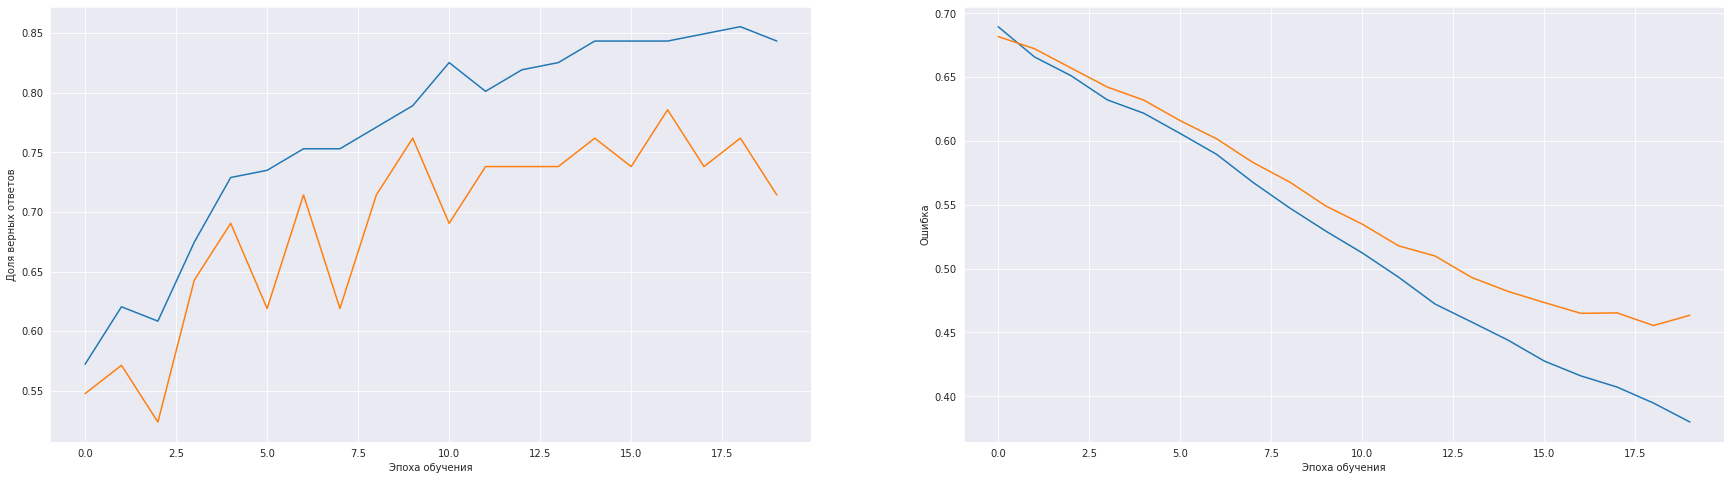

In [ ]:
worker.plot_graphic(history)

**Что такое эпохи?**

Структура созданной модели нейронной сети:

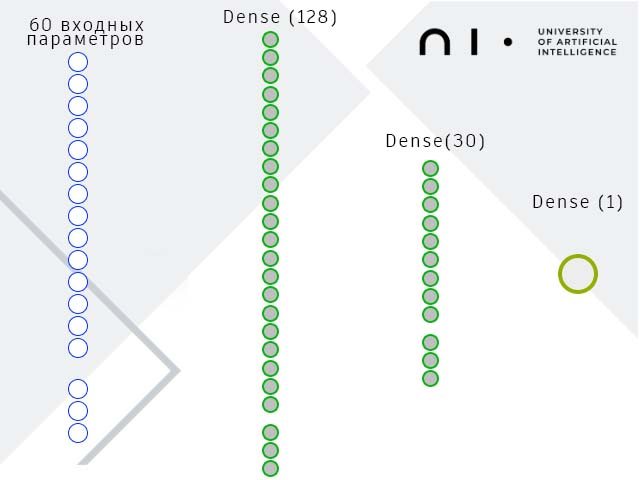

Обучающая выборка состоит из **166 примеров**. 

Обчение модели происходит по эпохам (в примере выше мы указали **количество эпох = 20**)

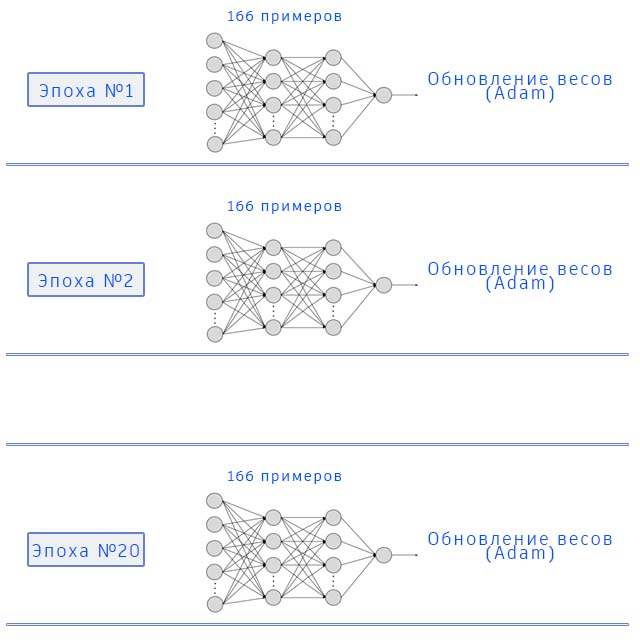

**Что такое batch_size?**

В рамках одной эпохи вся обучающая выборка может быть разбита на отдельные блоки (батчи). 

В этом случае веса нейронной сети обновляются после каждого батча. 

Для нашего примера (**batch_size=24**):

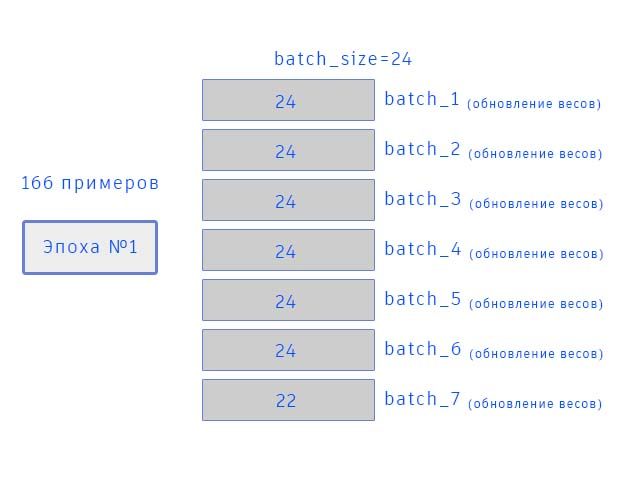

In [ ]:
worker.layers_demonstration(model)

Демонстрация работы Dense-слоя
Для примера возьмем случайную запись из тестовой выборки:
Параметры:
 [0.079  0.0707 0.0352 0.166  0.133  0.0226 0.0771 0.2678 0.5664 0.6609
 0.5002 0.2583 0.165  0.4347 0.4515 0.4579 0.3366 0.4    0.5325 0.901
 0.9939 0.3689 0.1012 0.0248 0.2318 0.3981 0.2259 0.5247 0.6898 0.8316
 0.4326 0.3741 0.5756 0.8043 0.7963 0.7174 0.7056 0.8148 0.7601 0.6034
 0.4554 0.4729 0.4478 0.3722 0.4693 0.3839 0.0768 0.1467 0.0777 0.0469
 0.0193 0.0298 0.039  0.0294 0.0175 0.0249 0.0141 0.0073 0.0025 0.0101]
Объект: мина


Работа нейронной сети
60 параметров подаются на вход нейронной сети

Значения поступают на 1-й слой (Dense), содержащий  128 нейронов
На выходе слоя получаем вектор из 128 значений:
+----------+----------+-----------+------------+-----------+------------+----------+----------+-----------+-----------+
| 0.604132 | 1.15439  | 0.171863  | 0.302165   | 0.489673  | 0.496329   | 0        | 0.345776 | 0.578201  | 0.0780953 |
+----------+----------+-----------+-

**Слой Batch Normalization**

Используется для нормализации входных значений. 

Номализация проводится в рамках всего батча обучения.

In [ ]:
# Создание модели
model = Sequential()

# Добавление слоев
model.add(BatchNormalization(input_dim=60))
model.add(Dense(128, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [ ]:
history = model.fit(worker.x_train,
          worker.y_train,
          validation_data=(worker.x_test, worker.y_test),
          batch_size=24,
          epochs=20,
          verbose=1)

Epoch 1/20
7/7 [==============================] - 2s 41ms/step - loss: 0.7435 - accuracy: 0.4458 - val_loss: 0.6940 - val_accuracy: 0.4762
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6168 - accuracy: 0.7169 - val_loss: 0.6817 - val_accuracy: 0.5476
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5291 - accuracy: 0.8313 - val_loss: 0.6728 - val_accuracy: 0.5476
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4784 - accuracy: 0.8133 - val_loss: 0.6637 - val_accuracy: 0.5476
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4125 - accuracy: 0.8494 - val_loss: 0.6554 - val_accuracy: 0.5476
Epoch 6/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3656 - accuracy: 0.8494 - val_loss: 0.6505 - val_accuracy: 0.5476
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3345 - accuracy: 0.9036 - val_loss: 0.6459 - val_accuracy: 0.5476
Epoch 8/20
7/7 [===============

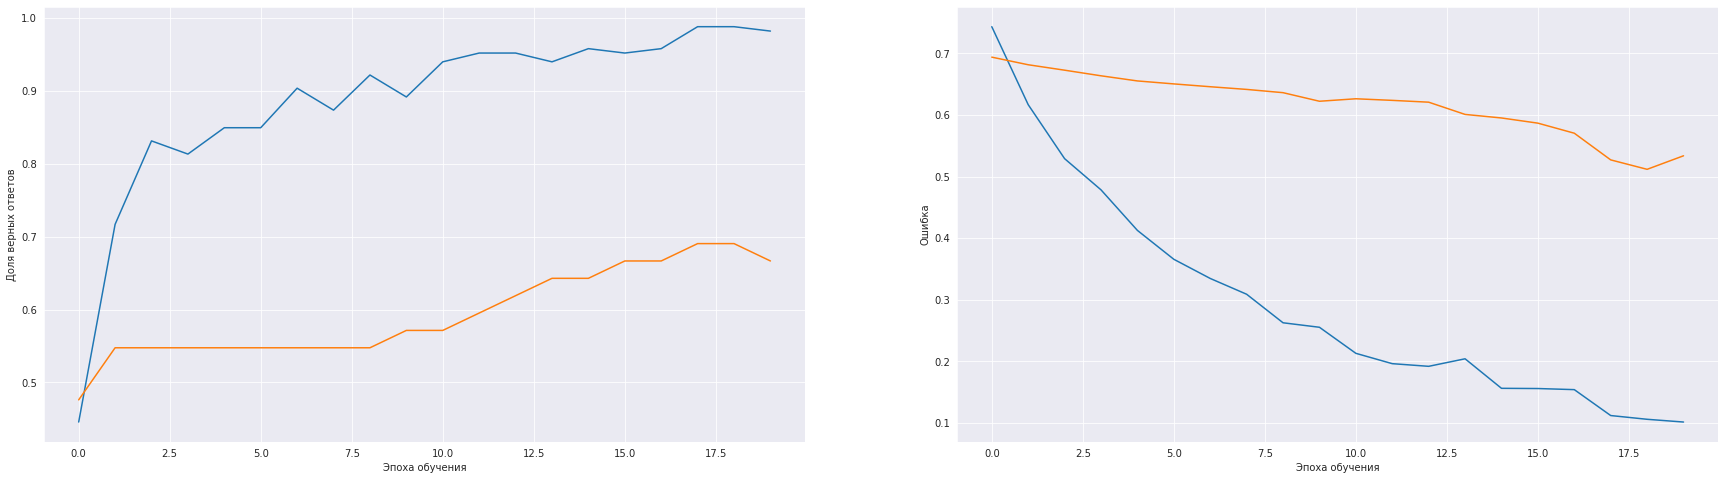

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration(model)

Демонстрация работы Dense-слоя
Для примера возьмем случайную запись из тестовой выборки:
Параметры:
 [0.0365 0.1632 0.1636 0.1421 0.113  0.1306 0.2112 0.2268 0.2992 0.3735
 0.3042 0.0387 0.2679 0.5397 0.6204 0.7257 0.835  0.6888 0.445  0.3921
 0.5605 0.7545 0.8311 1.     0.8762 0.7092 0.7009 0.5014 0.3942 0.4456
 0.4072 0.0773 0.1423 0.0401 0.3597 0.6847 0.7076 0.3597 0.0612 0.3027
 0.3966 0.3868 0.238  0.2059 0.2288 0.1704 0.1587 0.1792 0.1022 0.0151
 0.0223 0.011  0.0071 0.0205 0.0164 0.0063 0.0078 0.0094 0.011  0.0068]
Объект: камень


Работа нейронной сети
60 параметров подаются на вход нейронной сети

Значения поступают на 1-й слой (BatchNormalization)
На выходе слоя получаем вектор из 60 значений:
+-----------+------------+-------------+------------+-----------+------------+------------+--------------+-------------+------------+
| 0.0487567 |  0.291767  |  0.239375   |  0.19614   | 0.147156  | 0.0723743  |  0.278605  |  0.247219    |  0.352562   |  0.470186  |
+-----------+------

**Слой Dropout**

Используется для предотвращения переобучения нейронной сети.

«Выключает» часть нейронов на каждом батче обучения.

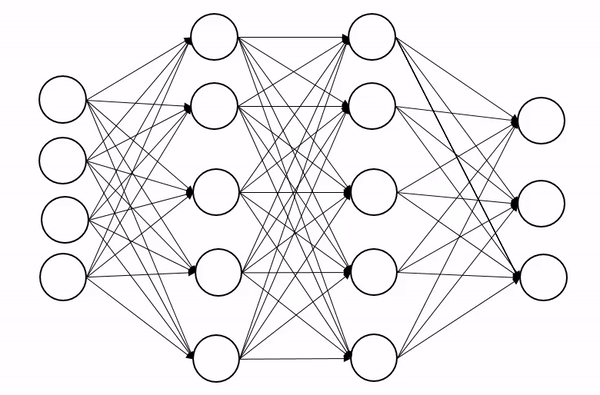

In [ ]:
# Создание модели
model = Sequential()

# Добавление слоев
model.add(BatchNormalization(input_dim=60))
model.add(Dense(128, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [ ]:
history = model.fit(worker.x_train,
          worker.y_train,
          validation_data=(worker.x_test, worker.y_test),
          batch_size=24,
          epochs=20,
          verbose=1)

Epoch 1/20
7/7 [==============================] - 2s 43ms/step - loss: 0.6481 - accuracy: 0.6145 - val_loss: 0.6698 - val_accuracy: 0.8095
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5110 - accuracy: 0.7590 - val_loss: 0.6676 - val_accuracy: 0.5238
Epoch 3/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4611 - accuracy: 0.8373 - val_loss: 0.6699 - val_accuracy: 0.5238
Epoch 4/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4207 - accuracy: 0.8373 - val_loss: 0.6708 - val_accuracy: 0.5238
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3855 - accuracy: 0.8614 - val_loss: 0.6607 - val_accuracy: 0.5238
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3564 - accuracy: 0.8976 - val_loss: 0.6482 - val_accuracy: 0.5476
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3306 - accuracy: 0.8916 - val_loss: 0.6464 - val_accuracy: 0.5476
Epoch 8/20
7/7 [===============

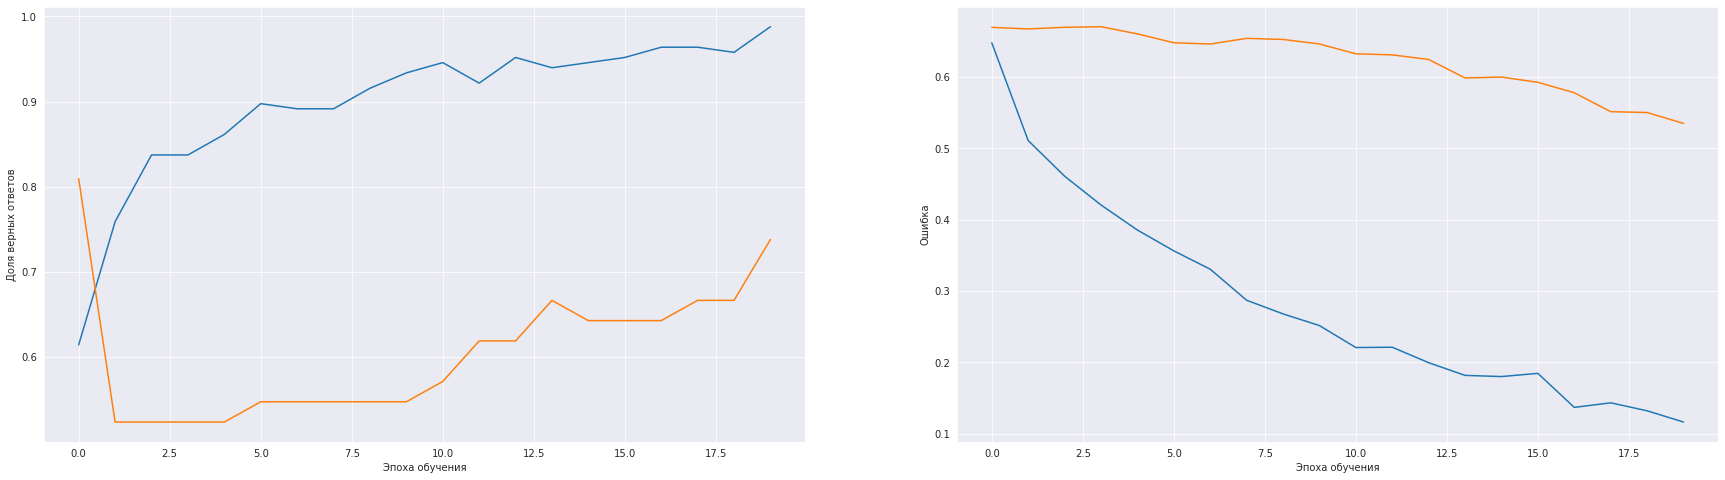

In [ ]:
worker.plot_graphic(history)

In [ ]:
worker.layers_demonstration(model)

Демонстрация работы Dense-слоя
Для примера возьмем случайную запись из тестовой выборки:
Параметры:
 [0.018  0.0444 0.0476 0.0698 0.1615 0.0887 0.0596 0.1071 0.3175 0.2918
 0.3273 0.3035 0.3033 0.2587 0.1682 0.1308 0.2803 0.4519 0.6641 0.7683
 0.696  0.4393 0.2432 0.2886 0.4974 0.8172 1.     0.9238 0.8519 0.7722
 0.5772 0.519  0.6824 0.622  0.5054 0.3578 0.3809 0.3813 0.3359 0.2771
 0.3648 0.3834 0.3453 0.2096 0.1031 0.0798 0.0701 0.0526 0.0241 0.0117
 0.0122 0.0122 0.0114 0.0098 0.0027 0.0025 0.0026 0.005  0.0073 0.0022]
Объект: мина


Работа нейронной сети
60 параметров подаются на вход нейронной сети

Значения поступают на 1-й слой (BatchNormalization)
На выходе слоя получаем вектор из 60 значений:
+------------+------------+-----------+------------+-------------+-------------+-------------+------------+------------+-------------+
| -0.0307918 |  0.0528671 |  0.044903 |  0.0401383 |  0.204709   |  0.0327931  | -0.0188018  |  0.0185509 |  0.404889  |  0.309284   |
+------------+-----